# 1 Load the libraries

In [82]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O


# Suppress all warnings
import warnings
warnings.filterwarnings("ignore")


# plotting libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


# Sklearn libraries
import sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler

# 2 Download stock data

In [35]:
def get_stock_data(stock_name):
    
    # For time stamps
    from datetime import datetime
    import yfinance as yf
    
    # The tech stocks we'll use for this analysis
    tech_list = [stock_name]

    dict_of_stocks = {}

    end = datetime.now()
    start = datetime(end.year - 16, end.month, end.day)

    for stock in tech_list:
        globals()[stock] = yf.download(stock, start, end)
        dict_of_stocks[tech_list[0]] = globals()[stock]
        

    return dict_of_stocks[tech_list[0]]

# 3 Inspecting the data

In [36]:
main_df = get_stock_data("KRI.AT")

[*********************100%***********************]  1 of 1 completed


In [37]:
main_df.head(), main_df.tail()

(                Open      High       Low     Close  Adj Close  Volume
 Date                                                                 
 2008-06-24  1.390587  1.390587  1.305882  1.390587   0.993292   35394
 2008-06-25  1.404705  1.404705  1.397646  1.404705   1.003376    9420
 2008-06-26  1.390587  1.425882  1.376470  1.418823   1.013461   13458
 2008-06-27  1.404705  1.475293  1.355293  1.432940   1.023544   99085
 2008-06-30  1.475293  1.489411  1.432940  1.447058   1.033629    7281,
              Open   High    Low  Close  Adj Close  Volume
 Date                                                     
 2024-06-17  10.80  10.85  10.45  10.60      10.60   14606
 2024-06-18  10.85  10.85  10.60  10.60      10.60   11018
 2024-06-19  10.60  10.75  10.60  10.70      10.70    9487
 2024-06-20  10.80  10.80  10.60  10.70      10.70   17631
 2024-06-21  10.65  10.75  10.60  10.65      10.65   17911)

# 4-2 Dataset timestamps

In [38]:
#Experiment_1

train_start_time = '2020-01-01'
train_end_time = '2023-03-31'

validation_start_time = '2023-04-01'
validation_end_time = '2023-04-30'

test_start_time = '2023-05-01'
test_end_time = '2023-05-31'
#test_end_time = str(main_df.index[-1].year)+"-"+str(main_df.index[-1].month)+"-"+str(main_df.index[-1].day)

# dataframe with performances

In [39]:
df_performances = pd.DataFrame(columns={'rmse', 'mape'})

# 5 Statistical Learning - Time Series

# Arima

Here I have a method that creates the train, validation and test set.

In [40]:
# 5 Statistical Learning - Time Series

def split_dataset_for_arima(main_df, 
                            train_start = '2020-01-01',
                            train_end = '2024-03-31', 
                            validation_start = '2024-04-01',
                            validation_end = '2024-04-30',
                            test_start = '2024-05-01',
                            test_end = '2023-05-30',
                            with_fe = False):
    

    # if feature engineering:
    if with_fe:
        main_df = financial_indicators(main_df.copy())


    # Split the data into train, validation, and test sets
    train_set = main_df[(main_df.index >= train_start) & (main_df.index <= train_end)]
    validation_set = main_df[(main_df.index >= validation_start) & (main_df.index <= validation_end)]
    train_and_validation_set = pd.concat([train_set, validation_set], axis=0)
    test_set = main_df[(main_df.index >= test_start) & (main_df.index <= test_end)]


    # Print the sizes of the sets
    print("Train Set Size:", len(train_set))
    print("Validation Set Size:", len(validation_set))
    print("Test Set Size:", len(test_set))


    print(test_set.tail(10))

    return train_set, validation_set, train_and_validation_set, test_set

In [41]:
train_set, validation_set, train_and_validation_set, test_set = split_dataset_for_arima(main_df.copy(), 
                                    train_start = train_start_time,
                                    train_end = train_end_time, 
                                    validation_start = validation_start_time,
                                    validation_end = validation_end_time,
                                    test_start = test_start_time,
                                    test_end = test_end_time,
                                    with_fe=False)

Train Set Size: 809
Validation Set Size: 16
Test Set Size: 22
            Open  High   Low  Close  Adj Close  Volume
Date                                                  
2023-05-18  7.10  7.12  7.00   7.00   6.833776    8531
2023-05-19  7.16  7.18  7.14   7.18   7.009501   11868
2023-05-22  7.30  7.32  7.18   7.32   7.146177    8112
2023-05-23  7.30  7.34  7.30   7.32   7.146177    7130
2023-05-24  7.34  7.44  7.32   7.34   7.165702    6415
2023-05-25  7.36  7.86  7.36   7.86   7.673354   23452
2023-05-26  7.98  8.36  7.94   8.16   7.966230   22286
2023-05-29  8.26  8.26  8.12   8.20   8.005280   47844
2023-05-30  8.14  8.16  7.90   8.16   7.966230   19014
2023-05-31  8.14  8.16  8.00   8.06   7.868605   67261


In [42]:
def auto_arima(df):

     import pmdarima as pm

     auto_arima_model = pm.auto_arima(df['Close'], start_p=1, d=None, start_q=1, max_p=5, max_d=2, max_q=5, start_P=1, D=None, start_Q=1, max_P=2, max_D=1, max_Q=2, max_order=5, m=1, seasonal=True, stationary=False,error_action='ignore',  
                              suppress_warnings=True,
                         stepwise=True, trace=True)
     
     return auto_arima_model

auto_arima_model = auto_arima(train_and_validation_set)

          

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1143.778, Time=0.65 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1128.020, Time=0.50 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1145.272, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1144.197, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1129.938, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1143.689, Time=0.44 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1141.292, Time=1.73 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-1147.163, Time=0.18 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-1145.584, Time=0.30 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1145.673, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-1146.086, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=1.26 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 5.950 seconds


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                   23
Model:                 ARIMA(1, 1, 0)   Log Likelihood                  12.124
Date:                Mon, 24 Jun 2024   AIC                            -20.248
Time:                        18:32:59   BIC                            -18.066
Sample:                             0   HQIC                           -19.734
                                 - 23                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4259      0.352      1.210      0.226      -0.264       1.116
sigma2         0.0193      0.003      6.405      0.000       0.013       0.025
Ljung-Box (L1) (Q):                   0.09   Jarque-

<Figure size 1100x300 with 0 Axes>

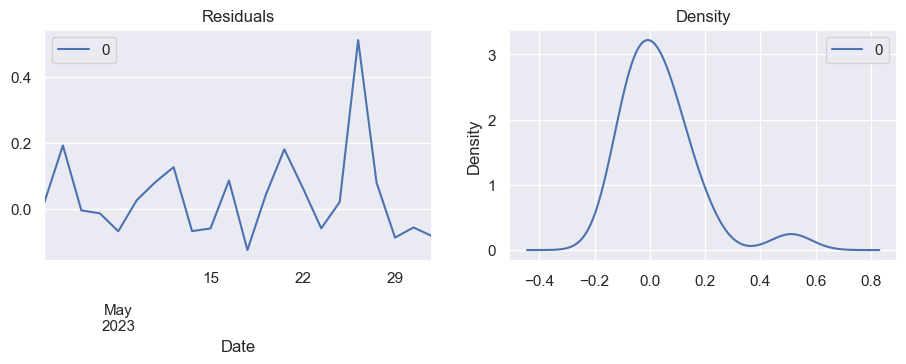

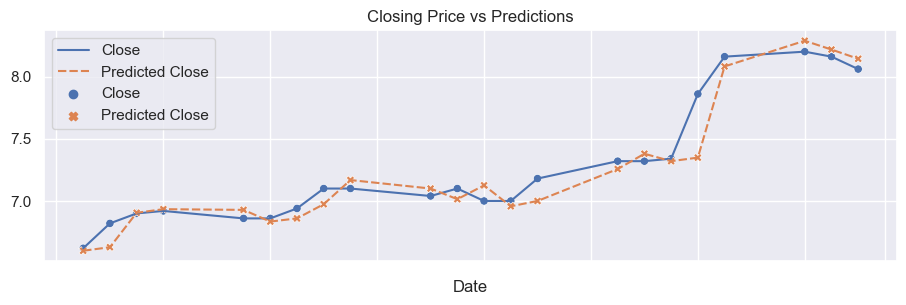

In [43]:
def build_arima_model(auto_arima_model, test_set):

    from statsmodels.tsa.arima.model import ARIMA

    # Fit the ARIMA model into the test set
    df = pd.concat([validation_set[-auto_arima_model.order[0]:], test_set])

    arima_model = ARIMA(df['Close'], order=(auto_arima_model.order[0], 
                                            auto_arima_model.order[1], 
                                            auto_arima_model.order[2]))




    arima_model_res = arima_model.fit()
    print(arima_model_res.summary())

    # create forecasts
    forecasts =  arima_model_res.predict(start=auto_arima_model.order[0], end=len(df)-1)
    print(len(forecasts))

    # evaluate forecasts against test_set
    from sklearn.metrics import mean_squared_error

    mse = mean_squared_error(test_set['Close'], forecasts)
    rmse = np.sqrt(mse)
    print(f"Root Mean Squared Error (RMSE): {rmse}")

    # Plot residual errors
    residuals = pd.DataFrame(arima_model_res.resid)[1:]
    
    plt.figure()
    fig, ax = plt.subplots(1,2)
    residuals.plot(title="Residuals", ax=ax[0])
    residuals.plot(kind='kde', title='Density', ax=ax[1])
    plt.show()


    #plot Close and predicted Close price
    plot_df = pd.DataFrame({'Date': test_set.index,
                       'Close': test_set['Close'],
                        'Predicted Close': forecasts
                            })


    my_plot = sns.set(rc={'figure.figsize':(11, 3)})
    plt.figure()
    my_plot = sns.scatterplot(plot_df)
    my_plot = sns.lineplot(plot_df)
    my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45)
    my_plot.set(title='Closing Price vs Predictions')

    df_performances.loc['Arima', 'rmse'] = rmse

    return arima_model, rmse

arima_model, arima_rmse = build_arima_model(auto_arima_model, test_set)

# Prepare for machine learning

In [44]:
def split_dataset_for_ml(main_df,
                        train_start = '2020-01-01',
                        train_end = '2022-12-31', 
                        validation_start = '2023-01-01',
                        validation_end = '2023-08-31',
                        test_start = '2023-09-01',
                        test_end = '2023-09-30',
                        best_lag_period = 0,
                        with_fe = False,
                        is_diffed = False):
    
    #####
    def get_datasets_after_finding_best_lags(main_df, columns, best_lag_period):

        for lag_period in range(1, best_lag_period+1):
        # Create lag features
            for feature in columns:
                main_df['{}_Lag_{}'.format(feature, lag_period)] = main_df[feature].shift(lag_period)

                # fill NaN values
                main_df.dropna(inplace=True)

        return main_df
    #####
    
    # get initial columns from main_df
    columns = main_df.copy().columns

    if best_lag_period>0:
        main_df = get_datasets_after_finding_best_lags(main_df.copy(), columns = columns, 
                                                       best_lag_period = best_lag_period)

    ### prepare for feature engineering
    if with_fe:
        main_df = financial_indicators(main_df.copy())
    
    # Prepare the closing price as target variable    
    main_df['target'] = main_df['Close'].shift(-1)

    if is_diffed == True:
        for col in columns:
            main_df[col] = main_df[col].diff(1).dropna()
        main_df['target'] = main_df['target'].diff(1).dropna()

            

    # Split the data into train, validation, and test sets
    train_set = main_df[(main_df.index >= train_start) & (main_df.index <= train_end)]
    validation_set = main_df[(main_df.index >= validation_start) & (main_df.index <= validation_end)]
    train_and_validation_set = pd.concat([train_set, validation_set], axis=0)

    test_set = main_df[(main_df.index >= test_start) & (main_df.index <= test_end)]
    test_set = test_set[:-1]


    return train_set, validation_set, train_and_validation_set, test_set

# Run 1

default models, default features

## Random Forest

In [83]:
def build_random_forest_default_model(main_df, with_fe=False):

    from sklearn.ensemble import RandomForestRegressor
    
    train_set, validation_set, train_and_validation_set, test_set = split_dataset_for_ml(main_df.copy(), 
                                train_start = train_start_time,
                                train_end = train_end_time,
                                validation_start = validation_start_time,
                                validation_end = validation_end_time,
                                test_start = test_start_time,
                                test_end = test_end_time,
                                best_lag_period = 0,
                                with_fe = with_fe,
                                is_diffed = False)


    scaler = StandardScaler()
    scaled_array = scaler.fit_transform(train_and_validation_set)
    train_data = pd.DataFrame(scaled_array, columns=train_and_validation_set.columns, index=train_and_validation_set.index)
    
    scaled_array = scaler.transform(test_set)
    test_data = pd.DataFrame(scaled_array, columns=test_set.columns, index=test_set.index)

    # Prepare the data for Random Forest
    X_train = train_data.drop(['target'], axis=1, inplace=False)
    y_train = train_data['target']

    X_test = test_data.drop(['target'], axis=1, inplace=False)
    y_test = test_data['target']
    
    
    # Train the Random Forest model
    model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=4)
    model.fit(X_train, y_train)

    # Make predictions using the trained model
    y_pred = model.predict(X_test)


    
    train_data = train_and_validation_set.copy()
    test_data = test_set.copy()
    y_pred = (y_pred * train_data['target'].std()) + train_data['target'].mean()
    
    test_data["y_pred"] = y_pred

    
    
    # Calculate RMSE (Root Mean Squared Error) to evaluate the model's performance
    rmse = np.sqrt(mean_squared_error(test_data["target"], test_data["y_pred"]))
    print(f"RMSE: {rmse}")

    # Calculate MAPE (Mean Absolute Percentage Error) to evaluate the model's performance
    mape = mean_absolute_percentage_error(test_data["target"], test_data["y_pred"])
    print(f"MAPE: {mape}")


    #plot Close and predicted Close price
    plot_df = pd.DataFrame({'Date': test_data.index,
                       'Close': test_data['target'],
                       'Predicted Close': test_data['y_pred']
                           })


    my_plot = sns.set(rc={'figure.figsize':(11, 3)})
    plt.figure()
    my_plot = sns.scatterplot(plot_df)
    my_plot = sns.lineplot(plot_df)
    my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45)
    my_plot.set(title='Closing Price vs Predictions')
    
    
    return model, rmse, mape

RMSE: 0.10193659786505505
MAPE: 0.010028893110044816


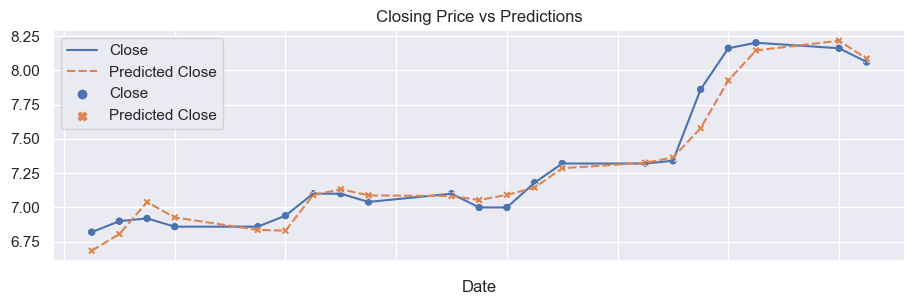

In [85]:
# Random Forest default model with default features
rf_model, rf_model_rmse, rf_model_mape = build_random_forest_default_model(main_df.copy(), 
                                                                    with_fe = False)

# Save the model performance
df_performances.loc['rf'] = rf_model_rmse

## XGBoost

In [86]:
def build_xgboost_default_model(main_df, with_fe=False):
    
    import xgboost as xgb
    
    train_set, validation_set, train_and_validation_set, test_set = split_dataset_for_ml(main_df.copy(), 
                                train_start = train_start_time,
                                train_end = train_end_time,
                                validation_start = validation_start_time,
                                validation_end = validation_end_time,
                                test_start = test_start_time,
                                test_end = test_end_time,
                                best_lag_period = 0,
                                with_fe = with_fe,
                                is_diffed = False)

    scaler = StandardScaler()
    scaled_array = scaler.fit_transform(train_and_validation_set)
    train_data = pd.DataFrame(scaled_array, columns=train_and_validation_set.columns, index=train_and_validation_set.index)
    
    scaled_array = scaler.transform(test_set)
    test_data = pd.DataFrame(scaled_array, columns=test_set.columns, index=test_set.index)
    
    # Prepare the data for Random Forest
    X_train = train_data.drop(['target'], axis=1, inplace=False)
    y_train = train_data['target']

    X_test = test_data.drop(['target'], axis=1, inplace=False)
    y_test = test_data['target']
    
    
    # Train the Random Forest model
    model = xgb.XGBRegressor(n_estimators=100, seed=42)
    model.fit(X_train, y_train)

    # Make predictions using the trained model
    y_pred = model.predict(X_test)


    train_data = train_and_validation_set.copy()
    test_data = test_set.copy()
    y_pred = (y_pred * train_data['target'].std()) + train_data['target'].mean()
    
    test_data["y_pred"] = y_pred
    
    # Calculate RMSE (Root Mean Squared Error) to evaluate the model's performance
    rmse = np.sqrt(mean_squared_error(test_data["target"], test_data["y_pred"]))
    print(f"RMSE: {rmse}")

    # Calculate MAPE (Mean Absolute Percentage Error) to evaluate the model's performance
    mape = mean_absolute_percentage_error(test_data["target"], test_data["y_pred"])
    print(f"MAPE: {mape}")


    #plot Close and predicted Close price
    plot_df = pd.DataFrame({'Date': test_data.index,
                       'Close': test_data['target'],
                       'Predicted Close': test_data['y_pred']
                           })


    my_plot = sns.set(rc={'figure.figsize':(11, 3)})
    plt.figure()
    my_plot = sns.scatterplot(plot_df)
    my_plot = sns.lineplot(plot_df)
    my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45)
    my_plot.set(title='Closing Price vs Predictions')
    
    
    return model, rmse, mape

RMSE: 0.10553999853909628
MAPE: 0.010272762918681745


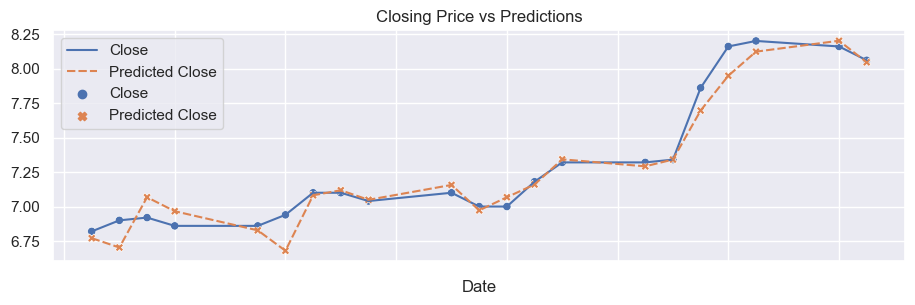

In [87]:
# build XGB model with lagged values and default parameters
xgb_model, xgb_model_rmse, xgb_model_mape = build_xgboost_default_model(main_df.copy(), with_fe=False)


# Save the model performance
df_performances.loc['xgb'] = xgb_model_rmse

## SVM

In [88]:
def build_svm_default_model(main_df, with_fe=False):
    
    from sklearn.svm import SVR
    
    train_set, validation_set, train_and_validation_set, test_set = split_dataset_for_ml(main_df.copy(), 
                                train_start = train_start_time,
                                train_end = train_end_time,
                                validation_start = validation_start_time,
                                validation_end = validation_end_time,
                                test_start = test_start_time,
                                test_end = test_end_time,
                                best_lag_period = 0,
                                with_fe = with_fe,
                                is_diffed = False)

    scaler = StandardScaler()
    scaled_array = scaler.fit_transform(train_and_validation_set)
    train_data = pd.DataFrame(scaled_array, columns=train_and_validation_set.columns, index=train_and_validation_set.index)
    
    scaled_array = scaler.transform(test_set)
    test_data = pd.DataFrame(scaled_array, columns=test_set.columns, index=test_set.index)
    
    # Prepare the data for Random Forest
    X_train = train_data.drop(['target'], axis=1, inplace=False)
    y_train = train_data['target']

    X_test = test_data.drop(['target'], axis=1, inplace=False)
    y_test = test_data['target']
    
    
    
    # Train the Random Forest model
    model = SVR(kernel='rbf')
    model.fit(X_train, y_train)

    # Make predictions using the trained model
    y_pred = model.predict(X_test)


    test_data["y_pred"] = y_pred


    train_data = train_and_validation_set.copy()
    test_data = test_set.copy()
    y_pred = (y_pred * train_data['target'].std()) + train_data['target'].mean()
    
    test_data["y_pred"] = y_pred
    
    # Calculate RMSE (Root Mean Squared Error) to evaluate the model's performance
    rmse = np.sqrt(mean_squared_error(test_data["target"], test_data["y_pred"]))
    print(f"RMSE: {rmse}")

    # Calculate MAPE (Mean Absolute Percentage Error) to evaluate the model's performance
    mape = mean_absolute_percentage_error(test_data["target"], test_data["y_pred"])
    print(f"MAPE: {mape}")


    #plot Close and predicted Close price
    plot_df = pd.DataFrame({'Date': test_data.index,
                       'Close': test_data['target'],
                       'Predicted Close': test_data['y_pred']
                           })


    my_plot = sns.set(rc={'figure.figsize':(11, 3)})
    plt.figure()
    my_plot = sns.scatterplot(plot_df)
    my_plot = sns.lineplot(plot_df)
    my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45)
    my_plot.set(title='Closing Price vs Predictions')
    
    
    return model, rmse, mape

RMSE: 0.22081721700234416
MAPE: 0.01291218483476649


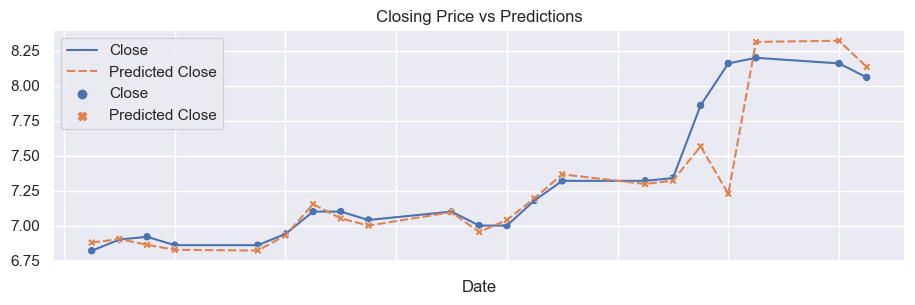

In [89]:
# build XGB model with lagged values and default parameters
svm_model, svm_model_rmse, svm_model_mape = build_svm_default_model(main_df.copy(), with_fe=False)


# Save the model performance
df_performances.loc['svm'] = svm_model_rmse

## kNN

In [51]:
def build_knn_default_model(main_df, with_fe = False):
    
    from sklearn.neighbors import KNeighborsRegressor

    train_set, validation_set, train_and_validation_set, test_set = split_dataset_for_ml(main_df.copy(), 
                                train_start = train_start_time,
                                train_end = train_end_time,
                                validation_start = validation_start_time,
                                validation_end = validation_end_time,
                                test_start = test_start_time,
                                test_end = test_end_time,
                                best_lag_period = 0,
                                with_fe = with_fe,
                                is_diffed = False)

    scaler = StandardScaler()
    scaled_array = scaler.fit_transform(train_and_validation_set)
    train_data = pd.DataFrame(scaled_array, columns=train_and_validation_set.columns, index=train_and_validation_set.index)
    
    scaled_array = scaler.transform(test_set)
    test_data = pd.DataFrame(scaled_array, columns=test_set.columns, index=test_set.index)
    
    # Prepare the data for Random Forest
    X_train = train_data.drop(['target'], axis=1, inplace=False)
    y_train = train_data['target']

    X_test = test_data.drop(['target'], axis=1, inplace=False)
    y_test = test_data['target']
    
    
    
    # Train the Random Forest model
    model = KNeighborsRegressor(n_neighbors=5)
    model.fit(X_train, y_train)

    # Make predictions using the trained model
    y_pred = model.predict(X_test)


    train_data = train_and_validation_set.copy()
    test_data = test_set.copy()
    y_pred = (y_pred * train_data['target'].std()) + train_data['target'].mean()
    
    test_data["y_pred"] = y_pred
    
    
    # Calculate RMSE (Root Mean Squared Error) to evaluate the model's performance
    rmse = np.sqrt(mean_squared_error(test_data["target"], test_data["y_pred"]))
    print(f"RMSE: {rmse}")


    # Calculate MAPE (Mean Absolute Percentage Error) to evaluate the model's performance
    mape = mean_absolute_percentage_error(test_data["target"], test_data["y_pred"])
    print(f"MAPE: {mape}")


    #plot Close and predicted Close price
    plot_df = pd.DataFrame({'Date': test_data.index,
                       'Close': test_data['target'],
                       'Predicted Close': test_data['y_pred']
                           })


    my_plot = sns.set(rc={'figure.figsize':(11, 3)})
    plt.figure()
    my_plot = sns.scatterplot(plot_df)
    my_plot = sns.lineplot(plot_df)
    my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45)
    my_plot.set(title='Closing Price vs Predictions')
    
    
    return model, rmse

RMSE: 0.1893019546999655


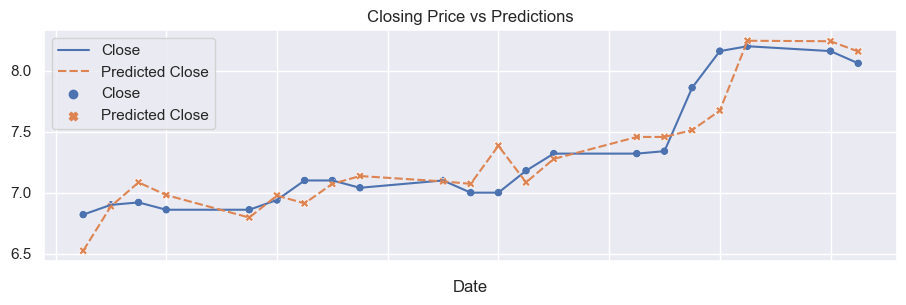

In [52]:
knn_model, knn_model_default_rmse, knn_model_default_mape = build_knn_default_model(main_df.copy(), with_fe=False)

# # Save the model performance
df_performances.loc['knn'] = knn_model_default_rmse

In [53]:
import tensorflow as tf

# Clear the session to free up resources
tf.keras.backend.clear_session()

## LSTM

In [54]:
def build_lstm_default_model(main_df, with_fe=False):
    
    import numpy as np
    import pandas as pd
    from sklearn.preprocessing import StandardScaler
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense
    from sklearn.metrics import mean_squared_error
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Set a random seed
    np.random.seed(42)

    train_set, validation_set, train_and_validation_set, test_set = split_dataset_for_ml(main_df.copy(), 
                            train_start = train_start_time,
                            train_end = train_end_time,
                            validation_start = validation_start_time,
                            validation_end = validation_end_time,
                            test_start = test_start_time,
                            test_end = test_end_time,
                            best_lag_period = 0,
                            is_diffed = False,
                            with_fe = with_fe)
    
    scaler = StandardScaler()
    scaled_array = scaler.fit_transform(train_and_validation_set)
    train_data = pd.DataFrame(scaled_array, columns=train_and_validation_set.columns, index=train_and_validation_set.index)
    
    scaled_array = scaler.transform(test_set)
    test_data = pd.DataFrame(scaled_array, columns=test_set.columns, index=test_set.index)
    
    # Prepare the data for LSTM
    X_train = train_data.drop(['target'], axis=1, inplace=False)
    y_train = train_data['target']

    X_test = test_data.drop(['target'], axis=1, inplace=False)
    y_test = test_data['target']
    
    # Reshape input to be 3D [samples, time steps, features]
    X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

    # Train the LSTM model
    lstm_model = Sequential()
    lstm_model.add(LSTM(10, input_shape=(X_train.shape[1], X_train.shape[2])))
    lstm_model.add(Dense(1))
    lstm_model.compile(loss='mean_squared_error', optimizer='adam')
    lstm_model.fit(X_train, y_train, epochs=10, batch_size=10, verbose=2)
    
    # Make predictions using the trained model
    y_pred = lstm_model.predict(X_test)
    
    # Rescale predictions back to the original scale
    train_data = train_and_validation_set.copy()
    test_data = test_set.copy()
    y_pred = (y_pred * train_data['target'].std()) + train_data['target'].mean()
    
    test_data["y_pred"] = y_pred
    
    # Calculate RMSE (Root Mean Squared Error) to evaluate the model's performance
    rmse = np.sqrt(mean_squared_error(test_data["target"], test_data["y_pred"]))
    print(f"RMSE: {rmse}")

    #plot Close and predicted Close price
    plot_df = pd.DataFrame({'Date': test_data.index,
                       'Close': test_data['target'],
                       'Predicted Close': test_data['y_pred']
                       })


    my_plot = sns.set(rc={'figure.figsize':(11, 3)})
    plt.figure()
    my_plot = sns.scatterplot(plot_df)
    my_plot = sns.lineplot(plot_df)
    my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45)
    my_plot.set(title='Closing Price vs Predictions')

    return lstm_model, rmse


Train on 825 samples
Epoch 1/10
825/825 - 2s - loss: 0.7801
Epoch 2/10
825/825 - 1s - loss: 0.3281
Epoch 3/10
825/825 - 1s - loss: 0.1024
Epoch 4/10
825/825 - 1s - loss: 0.0447
Epoch 5/10
825/825 - 1s - loss: 0.0328
Epoch 6/10
825/825 - 1s - loss: 0.0276
Epoch 7/10
825/825 - 1s - loss: 0.0242
Epoch 8/10
825/825 - 1s - loss: 0.0217
Epoch 9/10
825/825 - 2s - loss: 0.0196
Epoch 10/10
825/825 - 1s - loss: 0.0179
RMSE: 0.16285549178313358


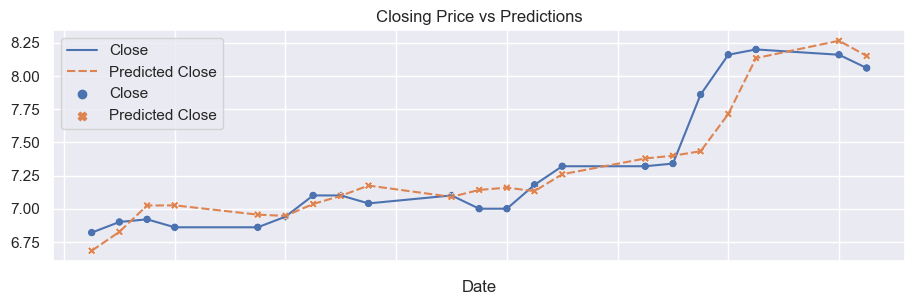

In [55]:
lstm_model, lstm_rmse = build_lstm_default_model(main_df.copy(), with_fe = False)

df_performances.loc['lstm'] = lstm_rmse

In [56]:
df_performances

,mape,rmse
Arima,NaN,0.13883
rf,0.185396,0.185396
xgb,0.205339,0.205339
svm,0.198597,0.198597
knn,0.189302,0.189302
lstm,0.162855,0.162855


# Run 2

tuned models and default features

## Random Forest

In [57]:
def build_random_forest_grid_search_model(main_df, with_fe = True):

    from sklearn.ensemble import RandomForestRegressor
    from sklearn.model_selection import GridSearchCV


    train_set, validation_set, train_and_validation_set, test_set = split_dataset_for_ml(main_df.copy(), 
                                    train_start = train_start_time,
                                    train_end = train_end_time,
                                    validation_start = validation_start_time,
                                    validation_end = validation_end_time,
                                    test_start = test_start_time,
                                    test_end = test_end_time,
                                    best_lag_period = 0,
                                    with_fe = with_fe,
                                    is_diffed = False)

    train_data = train_and_validation_set.copy()
    test_data = test_set.copy()

    # Prepare the data for Random Forest
    X_train = train_data.drop(['target'], axis=1, inplace=False)
    y_train = train_data['target']

    X_test = test_data.drop(['target'], axis=1, inplace=False)
    y_test = test_data['target']


    rf = RandomForestRegressor()
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth': [10, 20, 30, None]
    }

    rf_grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=2, n_jobs=-1, scoring='neg_mean_squared_error')
    rf_grid_search.fit(X_train, y_train)

    best_rf_model = rf_grid_search.best_estimator_
    print(rf_grid_search.best_params_)
    y_pred = best_rf_model.predict(X_test)


    test_data["y_pred"] = y_pred
        
    # Calculate RMSE (Root Mean Squared Error) to evaluate the model's performance
    rmse = np.sqrt(mean_squared_error(test_data["target"], test_data["y_pred"]))
    print(f"RMSE: {rmse}")


    #plot Close and predicted Close price
    plot_df = pd.DataFrame({'Date': test_data.index,
                        'Close': test_data['target'],
                        'Predicted Close': test_data['y_pred']
                            })


    my_plot = sns.set(rc={'figure.figsize':(11, 3)})
    plt.figure()
    my_plot = sns.scatterplot(plot_df)
    my_plot = sns.lineplot(plot_df)
    my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45)
    my_plot.set(title='Closing Price vs Predictions')

    return best_rf_model, rmse

{'max_depth': None, 'max_features': 'log2', 'n_estimators': 200}
RMSE: 0.17513124240274097


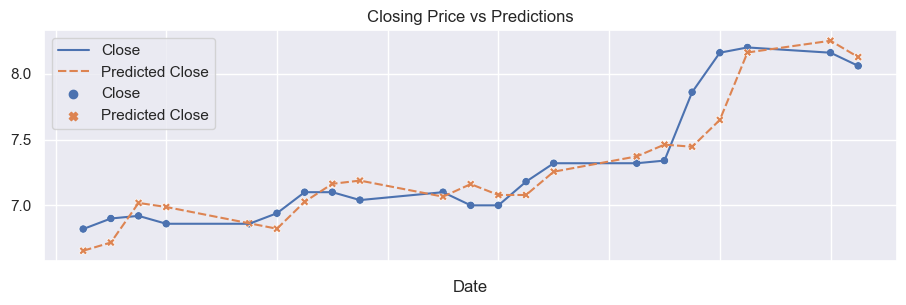

In [58]:
# Random Forest default model with default features
rf_model_grid, rf_model_grid_rmse = build_random_forest_grid_search_model(main_df.copy(), 
                                                                    with_fe = False)

# Save the model performance
df_performances.loc['rf_grid'] = rf_model_grid_rmse

## XGBoost

In [59]:
def build_xgboost_grid_search_model(main_df, with_fe = True):


    from sklearn.model_selection import GridSearchCV


    train_set, validation_set, train_and_validation_set, test_set = split_dataset_for_ml(main_df.copy(), 
                                    train_start = train_start_time,
                                    train_end = train_end_time,
                                    validation_start = validation_start_time,
                                    validation_end = validation_end_time,
                                    test_start = test_start_time,
                                    test_end = test_end_time,
                                    best_lag_period = 0,
                                    with_fe = with_fe,
                                    is_diffed = False)

    train_data = train_and_validation_set.copy()
    test_data = test_set.copy()

    # Prepare the data for Random Forest
    X_train = train_data.drop(['target'], axis=1, inplace=False)
    y_train = train_data['target']

    X_test = test_data.drop(['target'], axis=1, inplace=False)
    y_test = test_data['target']


    from xgboost import XGBRegressor

    xgb = XGBRegressor()
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4],
        'max_depth': [3, 5, 7, 9]
    }

    xgb_grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=2, n_jobs=-1, scoring='neg_mean_squared_error')
    xgb_grid_search.fit(X_train, y_train)

    best_xgb_model = xgb_grid_search.best_estimator_
    print(xgb_grid_search.best_params_)
    y_pred = best_xgb_model.predict(X_test)


    test_data["y_pred"] = y_pred
        
    # Calculate RMSE (Root Mean Squared Error) to evaluate the model's performance
    rmse = np.sqrt(mean_squared_error(test_data["target"], test_data["y_pred"]))
    print(f"RMSE: {rmse}")


    #plot Close and predicted Close price
    plot_df = pd.DataFrame({'Date': test_data.index,
                        'Close': test_data['target'],
                        'Predicted Close': test_data['y_pred']
                            })


    my_plot = sns.set(rc={'figure.figsize':(11, 3)})
    plt.figure()
    my_plot = sns.scatterplot(plot_df)
    my_plot = sns.lineplot(plot_df)
    my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45)
    my_plot.set(title='Closing Price vs Predictions')

    return best_xgb_model, rmse

{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50}
RMSE: 0.22461989108964253


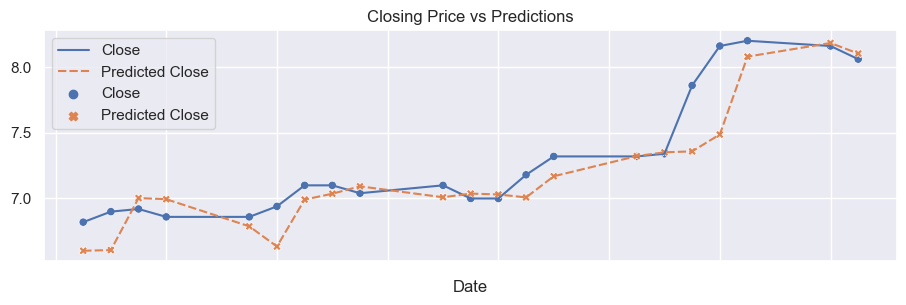

In [60]:
# Random Forest default model with feature engineering
xgb_model_grid, xgb_model_grid_rmse = build_xgboost_grid_search_model(main_df.copy(), 
                                                                    with_fe = False)

# Save the model performance
df_performances.loc['xgb_grid'] = xgb_model_grid_rmse

## kNN

In [61]:
def build_knn_grid_search_model(main_df, with_fe = True):

    from sklearn.model_selection import GridSearchCV


    train_set, validation_set, train_and_validation_set, test_set = split_dataset_for_ml(main_df.copy(), 
                                    train_start = train_start_time,
                                    train_end = train_end_time,
                                    validation_start = validation_start_time,
                                    validation_end = validation_end_time,
                                    test_start = test_start_time,
                                    test_end = test_end_time,
                                    best_lag_period = 0,
                                    with_fe = with_fe,
                                    is_diffed = False)

    train_data = train_and_validation_set.copy()
    test_data = test_set.copy()

    # Prepare the data for Random Forest
    X_train = train_data.drop(['target'], axis=1, inplace=False)
    y_train = train_data['target']

    X_test = test_data.drop(['target'], axis=1, inplace=False)
    y_test = test_data['target']


    from sklearn.neighbors import KNeighborsRegressor

    knn = KNeighborsRegressor()
    param_grid = {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }

    knn_grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=2, n_jobs=-1, scoring='neg_mean_squared_error')
    knn_grid_search.fit(X_train, y_train)

    best_knn_model = knn_grid_search.best_estimator_
    print(knn_grid_search.best_params_)
    y_pred = best_knn_model.predict(X_test)


    test_data["y_pred"] = y_pred
        
    # Calculate RMSE (Root Mean Squared Error) to evaluate the model's performance
    rmse = np.sqrt(mean_squared_error(test_data["target"], test_data["y_pred"]))
    print(f"RMSE: {rmse}")


    #plot Close and predicted Close price
    plot_df = pd.DataFrame({'Date': test_data.index,
                        'Close': test_data['target'],
                        'Predicted Close': test_data['y_pred']
                            })


    my_plot = sns.set(rc={'figure.figsize':(11, 3)})
    plt.figure()
    my_plot = sns.scatterplot(plot_df)
    my_plot = sns.lineplot(plot_df)
    my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45)
    my_plot.set(title='Closing Price vs Predictions')

    return best_knn_model, rmse

RMSE: 0.1893019546999655


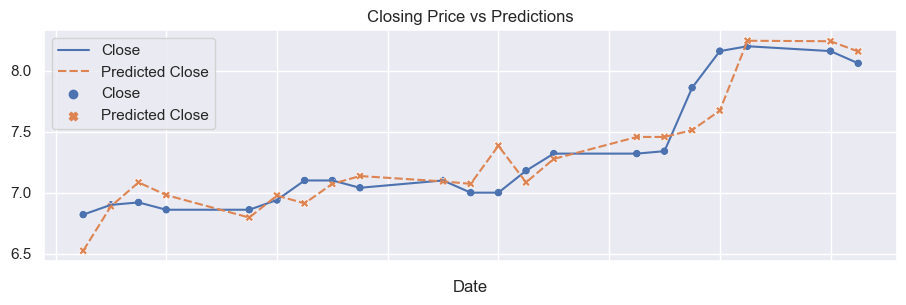

In [62]:
knn_model_grid, knn_model_grid_rmse = build_knn_default_model(main_df.copy(), with_fe=False)

# Save the model performance
df_performances.loc['knn'] = knn_model_grid_rmse

## SVM

In [63]:
def build_svm_grid_search_model(main_df, with_fe = True):


    from sklearn.model_selection import GridSearchCV


    train_set, validation_set, train_and_validation_set, test_set = split_dataset_for_ml(main_df.copy(), 
                                    train_start = train_start_time,
                                    train_end = train_end_time,
                                    validation_start = validation_start_time,
                                    validation_end = validation_end_time,
                                    test_start = test_start_time,
                                    test_end = test_end_time,
                                    best_lag_period = 0,
                                    with_fe = True,
                                    is_diffed = False)

    train_data = train_and_validation_set.copy()
    test_data = test_set.copy()

    # Prepare the data for Random Forest
    X_train = train_data.drop(['target'], axis=1, inplace=False)
    y_train = train_data['target']

    X_test = test_data.drop(['target'], axis=1, inplace=False)
    y_test = test_data['target']


    from sklearn.svm import SVR

    svm = SVR()
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': [1e-4, 1e-3, 1e-2, 1e-1],
        'kernel': ['rbf']
    }

    svm_grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=2, n_jobs=-1, scoring='neg_mean_squared_error')
    svm_grid_search.fit(X_train, y_train)

    best_svm_model = svm_grid_search.best_estimator_
    print(svm_grid_search.best_params_)
    y_pred = best_svm_model.predict(X_test)



    test_data["y_pred"] = y_pred
        
    # Calculate RMSE (Root Mean Squared Error) to evaluate the model's performance
    rmse = np.sqrt(mean_squared_error(test_data["target"], test_data["y_pred"]))
    print(f"RMSE: {rmse}")


    #plot Close and predicted Close price
    plot_df = pd.DataFrame({'Date': test_data.index,
                        'Close': test_data['target'],
                        'Predicted Close': test_data['y_pred']
                            })


    my_plot = sns.set(rc={'figure.figsize':(11, 3)})
    plt.figure()
    my_plot = sns.scatterplot(plot_df)
    my_plot = sns.lineplot(plot_df)
    my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45)
    my_plot.set(title='Closing Price vs Predictions')


    return best_svm_model, rmse

RMSE: 0.19859725122617655


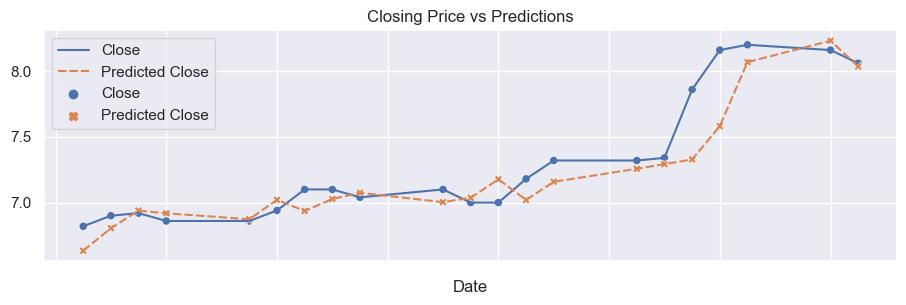

In [64]:
svm_model_grid, svm_model_grid_rmse = build_svm_default_model(main_df.copy(), with_fe=False)

# Save the model performance
df_performances.loc['svm_grid'] = svm_model_grid_rmse

## LSTM

In [65]:
def build_lstm_grid_search_model(main_df, with_fe = True):


    import numpy as np
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense
    from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
    from sklearn.model_selection import GridSearchCV

    train_set, validation_set, train_and_validation_set, test_set = split_dataset_for_ml(main_df.copy(), 
                                    train_start = train_start_time,
                                    train_end = train_end_time,
                                    validation_start = validation_start_time,
                                    validation_end = validation_end_time,
                                    test_start = test_start_time,
                                    test_end = test_end_time,
                                    best_lag_period = 0,
                                    with_fe = with_fe,
                                    is_diffed = False)
    

    scaler = StandardScaler()
    scaled_array = scaler.fit_transform(train_and_validation_set)
    train_data = pd.DataFrame(scaled_array, columns=train_and_validation_set.columns, index=train_and_validation_set.index)
    
    scaled_array = scaler.transform(test_set)
    test_data = pd.DataFrame(scaled_array, columns=test_set.columns, index=test_set.index)

    # Prepare the data for Random Forest
    X_train = train_data.drop(['target'], axis=1, inplace=False)
    y_train = train_data['target']

    X_test = test_data.drop(['target'], axis=1, inplace=False)
    y_test = test_data['target']


    # Reshape input to be 3D [samples, time steps, features]
    X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))


    def create_lstm_model(units=10, optimizer='adam'):
        model = Sequential()
        model.add(LSTM(units, input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer=optimizer)
        return model

    lstm_model = KerasRegressor(build_fn=create_lstm_model, verbose=2)

    param_grid = {
        'units': [10, 20, 30],
        'batch_size': [5, 10, 15],
        'epochs': [10, 15, 20],
        'optimizer': ['adam', 'rmsprop']
    }

    lstm_grid_search = GridSearchCV(estimator=lstm_model, param_grid=param_grid, cv=2, n_jobs=-1)
    lstm_grid_search.fit(X_train, y_train)

    best_lstm_model = lstm_grid_search.best_estimator_
    print(lstm_grid_search.best_params_)
    y_pred = best_lstm_model.predict(X_test)

    # Rescale predictions back to the original scale
    train_data = train_and_validation_set.copy()
    test_data = test_set.copy()
    y_pred = (y_pred * train_data['target'].std()) + train_data['target'].mean()
    
    test_data["y_pred"] = y_pred
        
    # Calculate RMSE (Root Mean Squared Error) to evaluate the model's performance
    rmse = np.sqrt(mean_squared_error(test_data["target"], test_data["y_pred"]))
    print(f"RMSE: {rmse}")


    #plot Close and predicted Close price
    plot_df = pd.DataFrame({'Date': test_data.index,
                        'Close': test_data['target'],
                        'Predicted Close': test_data['y_pred']
                            })


    my_plot = sns.set(rc={'figure.figsize':(11, 3)})
    plt.figure()
    my_plot = sns.scatterplot(plot_df)
    my_plot = sns.lineplot(plot_df)
    my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45)
    my_plot.set(title='Closing Price vs Predictions')


    return best_lstm_model, rmse


Train on 825 samples
Epoch 1/20
825/825 - 4s - loss: 0.1713
Epoch 2/20
825/825 - 2s - loss: 0.0215
Epoch 3/20
825/825 - 2s - loss: 0.0181
Epoch 4/20
825/825 - 2s - loss: 0.0166
Epoch 5/20
825/825 - 1s - loss: 0.0150
Epoch 6/20
825/825 - 2s - loss: 0.0138
Epoch 7/20
825/825 - 2s - loss: 0.0130
Epoch 8/20
825/825 - 1s - loss: 0.0129
Epoch 9/20
825/825 - 2s - loss: 0.0123
Epoch 10/20
825/825 - 2s - loss: 0.0123
Epoch 11/20
825/825 - 2s - loss: 0.0123
Epoch 12/20
825/825 - 2s - loss: 0.0121
Epoch 13/20
825/825 - 1s - loss: 0.0118
Epoch 14/20
825/825 - 2s - loss: 0.0116
Epoch 15/20
825/825 - 1s - loss: 0.0118
Epoch 16/20
825/825 - 1s - loss: 0.0118
Epoch 17/20
825/825 - 1s - loss: 0.0119
Epoch 18/20
825/825 - 2s - loss: 0.0118
Epoch 19/20
825/825 - 1s - loss: 0.0119
Epoch 20/20
825/825 - 1s - loss: 0.0117
{'batch_size': 5, 'epochs': 20, 'optimizer': 'adam', 'units': 30}
21/21 - 0s
RMSE: 0.1582672196390912


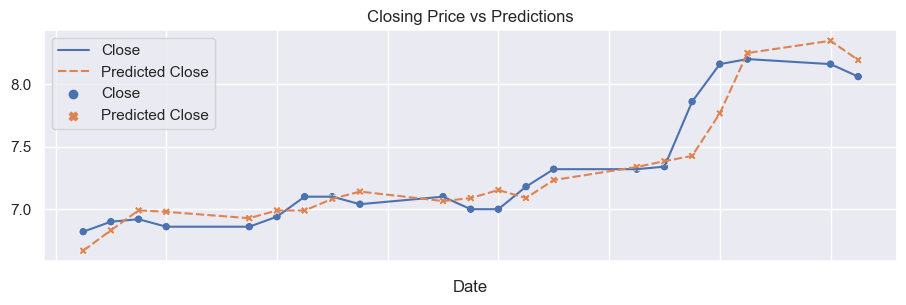

In [66]:
lstm_model_grid, lstm_model_grid_rmse = build_lstm_grid_search_model(main_df.copy(), with_fe=False)

# Save the model performance
df_performances.loc['lstm_grid'] = lstm_model_grid_rmse

# Run 3

default models and feature engineering

## Feature Engineering - Creating Financial Indicators

In [67]:
def financial_indicators(main_df):

    import pandas_ta as ta

    # simple moving average
    sma = ta.sma(main_df["Close"], length=2)
    main_df['sma'] = sma

    # Weighted Moving Average: wma
    wma = ta.wma(main_df["Close"], length=2)
    main_df['wma'] = wma

    # Momemtum
    mom = ta.mom(main_df["Close"], length=2)
    main_df['mom'] = mom

    # stochastic ochilator
    stoch = ta.stoch(high = main_df["High"], low = main_df["Low"], close = main_df["Close"])
    main_df['stoch_k'] = stoch["STOCHk_14_3_3"]
    main_df['stoch_d'] = stoch["STOCHd_14_3_3"]

    # RSI
    rsi = ta.rsi(main_df["Close"], length=2)
    main_df['rsi'] = rsi

    # MACD
    macd = ta.macd(main_df["Close"])
    main_df['macd'] = macd['MACD_12_26_9']

    # William's R
    willr = ta.willr(high = main_df["High"], low = main_df["Low"], close = main_df["Close"], length=7)
    main_df['willr'] = willr

    # A/D (Accumulation/Distribution) Oscillator
    adosc = ta.adosc(high = main_df["High"], low = main_df["Low"], close = main_df["Close"], volume = main_df['Volume'])
    main_df['adosc'] = adosc

    # Commodity Channel Index: cci
    cci = ta.cci(high = main_df["High"], low = main_df["Low"], close = main_df["Close"])
    main_df['cci'] = cci

    main_df.dropna(inplace=True)

    return main_df

## XGBoost

RMSE: 0.22514322299263453


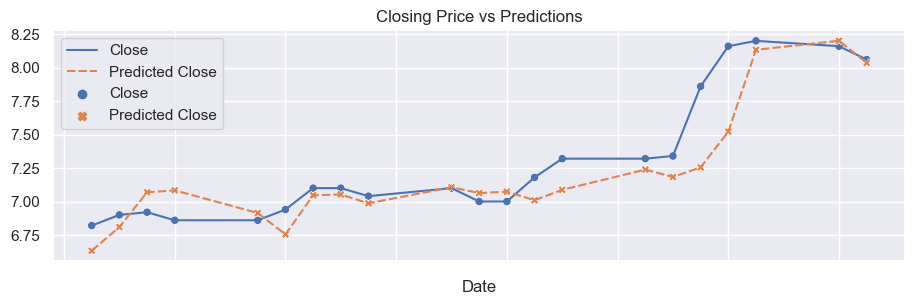

In [68]:
# build XGB model with lagged values and default parameters
xgb_model_fe, xgb_model_fe_rmse = build_xgboost_default_model(main_df.copy(), with_fe=True)


# Save the model performance
df_performances.loc['xgb_fe'] = xgb_model_fe_rmse

## Random Forest

RMSE: 0.17641584945212965


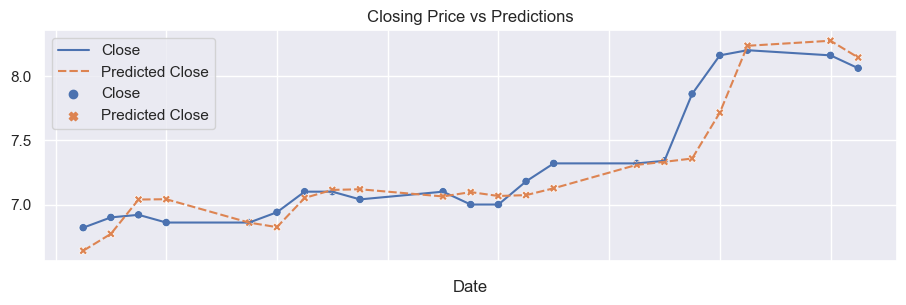

In [69]:
# Random Forest default model with default features
rf_model_fe, rf_model_fe_rmse = build_random_forest_default_model(main_df.copy(), 
                                                                    with_fe = True)

# Save the model performance
df_performances.loc['rf_fe'] = rf_model_fe_rmse

## SVM

RMSE: 0.250590511669591


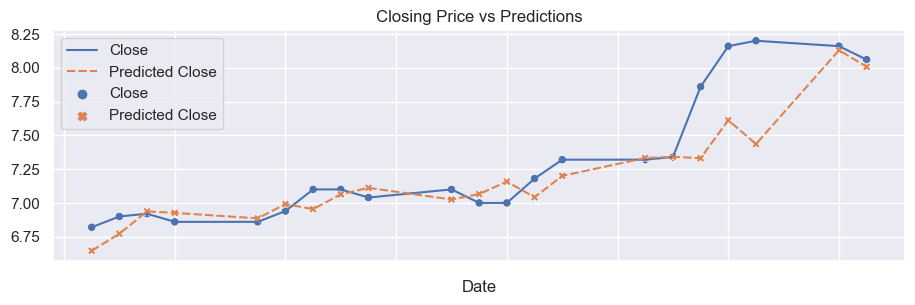

In [70]:
# build XGB model with lagged values and default parameters
svm_model_fe, svm_model_fe_rmse = build_svm_default_model(main_df.copy(), with_fe=True)


# Save the model performance
df_performances.loc['svm_fe'] = svm_model_rmse

## kNN

RMSE: 0.19020637370429705


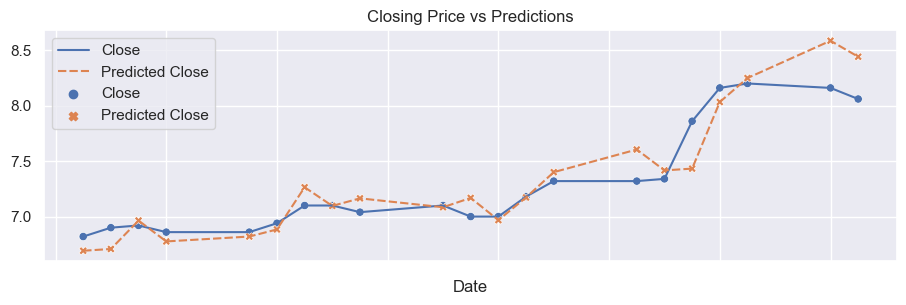

In [71]:
knn_model_fe, knn_model_fe_rmse = build_knn_default_model(main_df.copy(), with_fe=True)

# # Save the model performance
df_performances.loc['knn_fe'] = knn_model_fe_rmse

## LSTM

Train on 825 samples
Epoch 1/10
825/825 - 2s - loss: 0.6029
Epoch 2/10
825/825 - 1s - loss: 0.2977
Epoch 3/10
825/825 - 1s - loss: 0.1512
Epoch 4/10
825/825 - 1s - loss: 0.0879
Epoch 5/10
825/825 - 1s - loss: 0.0615
Epoch 6/10
825/825 - 1s - loss: 0.0466
Epoch 7/10
825/825 - 1s - loss: 0.0364
Epoch 8/10
825/825 - 1s - loss: 0.0291
Epoch 9/10
825/825 - 1s - loss: 0.0243
Epoch 10/10
825/825 - 1s - loss: 0.0210
RMSE: 0.24883826993287528


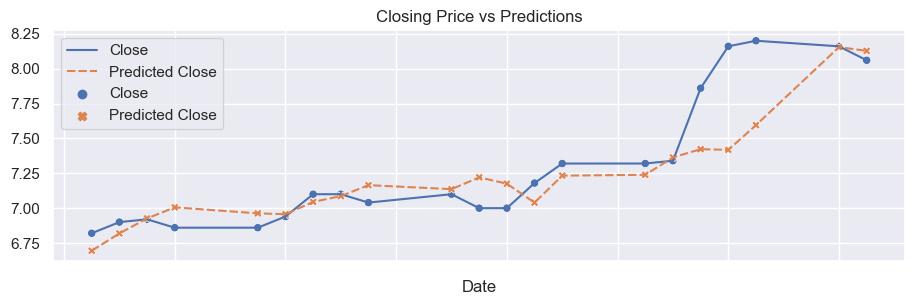

In [72]:
lstm_model_fe, lstm_model_fe_rmse = build_lstm_default_model(main_df.copy(), with_fe = True)

df_performances.loc['lstm_fe'] = lstm_model_fe_rmse

# Run 4

Tuned models with feature engineering

## Random Forest

{'max_depth': 20, 'max_features': 'log2', 'n_estimators': 100}
RMSE: 0.16744981550854623


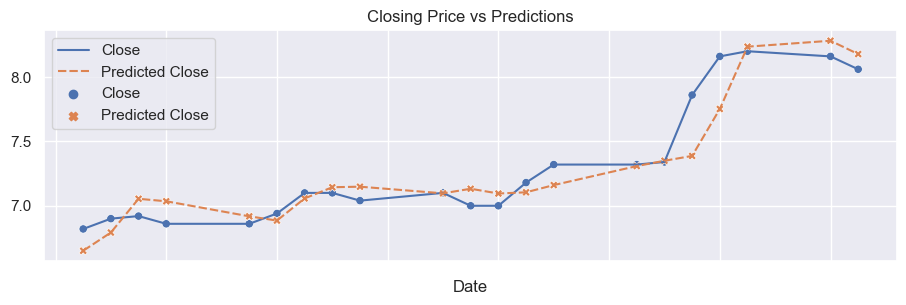

In [73]:
# Random Forest default model with default features
rf_model_grid_fe, rf_model_grid_fe_rmse = build_random_forest_grid_search_model(main_df.copy(), 
                                                                    with_fe = True)

# Save the model performance
df_performances.loc['rf_grid_fe'] = rf_model_grid_fe_rmse

## XGBoost

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
RMSE: 0.21937715238299993


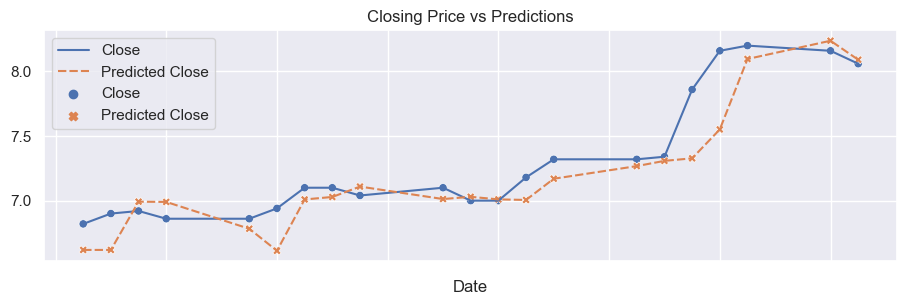

In [74]:
# Random Forest default model with feature engineering
xgb_model_grid_fe, xgb_model_grid_fe_rmse = build_xgboost_grid_search_model(main_df.copy(), 
                                                                    with_fe = True)

# Save the model performance
df_performances.loc['xgb_grid_fe'] = xgb_model_grid_fe_rmse

## kNN

RMSE: 0.19020637370429705


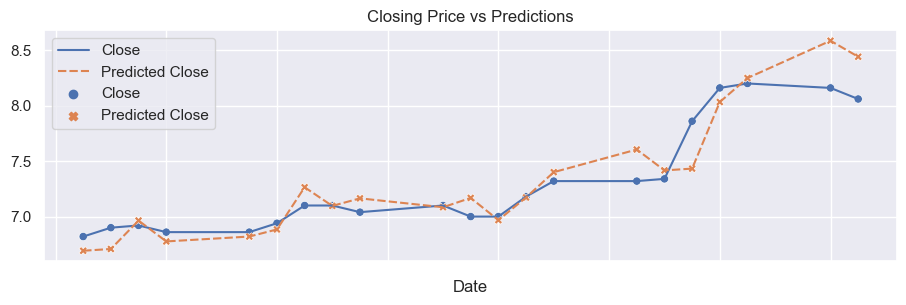

In [75]:
knn_model_grid_fe, knn_model_grid_fe_rmse = build_knn_default_model(main_df.copy(), with_fe=True)

# Save the model performance
df_performances.loc['knn_grid_fe'] = knn_model_grid_fe_rmse

## SVM

RMSE: 0.250590511669591


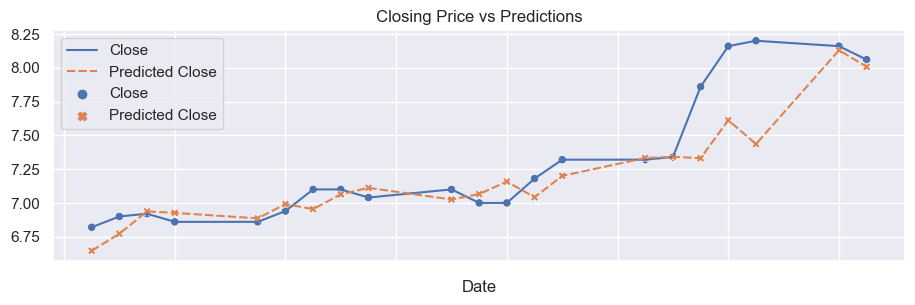

In [76]:
svm_model_grid, svm_model_grid_fe_rmse = build_svm_default_model(main_df.copy(), with_fe=True)

# Save the model performance
df_performances.loc['svm_grid_fe'] = svm_model_grid_fe_rmse

## LSTM

Train on 825 samples
Epoch 1/15
825/825 - 3s - loss: 0.2288
Epoch 2/15
825/825 - 1s - loss: 0.0221
Epoch 3/15
825/825 - 1s - loss: 0.0172
Epoch 4/15
825/825 - 1s - loss: 0.0150
Epoch 5/15
825/825 - 2s - loss: 0.0132
Epoch 6/15
825/825 - 1s - loss: 0.0129
Epoch 7/15
825/825 - 1s - loss: 0.0123
Epoch 8/15
825/825 - 2s - loss: 0.0120
Epoch 9/15
825/825 - 2s - loss: 0.0116
Epoch 10/15
825/825 - 2s - loss: 0.0115
Epoch 11/15
825/825 - 2s - loss: 0.0117
Epoch 12/15
825/825 - 1s - loss: 0.0109
Epoch 13/15
825/825 - 1s - loss: 0.0111
Epoch 14/15
825/825 - 2s - loss: 0.0115
Epoch 15/15
825/825 - 1s - loss: 0.0113
{'batch_size': 5, 'epochs': 15, 'optimizer': 'adam', 'units': 30}
21/21 - 0s
RMSE: 0.16881217920382335


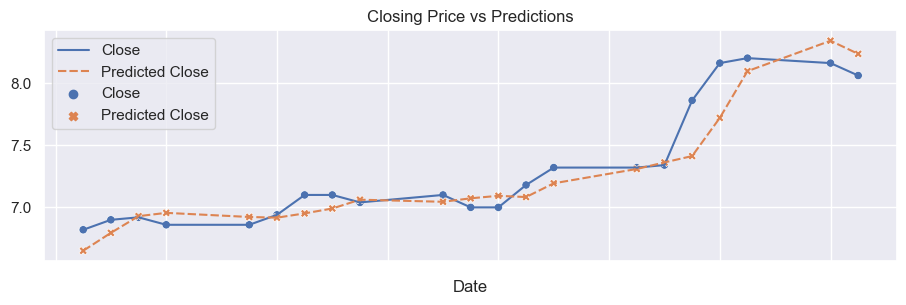

In [77]:
lstm_model_grid_fe, lstm_model_grid_fe_rmse = build_lstm_grid_search_model(main_df.copy(), with_fe=True)

# Save the model performance
df_performances.loc['lstm_grid_fe'] = lstm_model_grid_fe_rmse

In [78]:
df_performances

,mape,rmse
Arima,NaN,0.13883
rf,0.185396,0.185396
xgb,0.205339,0.205339
svm,0.198597,0.198597
knn,0.189302,0.189302
lstm,0.162855,0.162855
rf_grid,0.175131,0.175131
xgb_grid,0.22462,0.22462
svm_grid,0.198597,0.198597
lstm_grid,0.158267,0.158267


# Future Experimentiments

In [79]:
main_df['Open-Close'] = main_df['Open'] - main_df['Close']
main_df['High-Close'] = main_df['High'] - main_df['Close']
main_df['Low-Close'] = main_df['Low'] - main_df['Close']
main_df['Target'] =  main_df['Close'].shift(-1) - main_df['Close']
main_df

,Open,High,Low,Close,Adj Close,Volume,Open-Close,High-Close,Low-Close,Target
Date,,,,,,,,,,
2008-06-24,1.390587,1.390587,1.305882,1.390587,0.993292,35394,0.000000,0.000000,-0.084705,0.014118
2008-06-25,1.404705,1.404705,1.397646,1.404705,1.003376,9420,0.000000,0.000000,-0.007059,0.014118
2008-06-26,1.390587,1.425882,1.376470,1.418823,1.013461,13458,-0.028236,0.007059,-0.042353,0.014117
2008-06-27,1.404705,1.475293,1.355293,1.432940,1.023544,99085,-0.028235,0.042353,-0.077647,0.014118
2008-06-30,1.475293,1.489411,1.432940,1.447058,1.033629,7281,0.028235,0.042353,-0.014118,-0.028235
...,...,...,...,...,...,...,...,...,...,...
2024-06-17,10.800000,10.850000,10.450000,10.600000,10.600000,14606,0.200000,0.250000,-0.150001,0.000000
2024-06-18,10.850000,10.850000,10.600000,10.600000,10.600000,11018,0.250000,0.250000,0.000000,0.099999
2024-06-19,10.600000,10.750000,10.600000,10.700000,10.700000,9487,-0.099999,0.050000,-0.099999,0.000000
